<a href="https://colab.research.google.com/github/gorzanskik-ai/short-term-stocks-price-prediction/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 4.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=a0e1f2fa5eea5a073b18581f8e5adad1a75cd21dd6c094db39c5a7e0b003a754
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as pta
import plotly.express as px

path = "/content/drive/MyDrive/master's thesis/day/^spx_d.csv"
raw_data = pd.read_csv(path)
df_raw = raw_data.copy()
df_raw.index = df_raw.Date
df_raw = df_raw.dropna()
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw.index = df_raw.Date
df_raw = df_raw.drop('Date', axis=1)

path2 = "/content/drive/MyDrive/master's thesis/day/investment.csv"
raw_data2 = pd.read_csv(path2)
df_raw2 = raw_data2.copy()
df_raw2.index = df_raw2.Date
df_raw2 = df_raw2.dropna()
df_raw2['Date'] = pd.to_datetime(df_raw2['Date'])
df_raw2.index = df_raw2.Date
df_raw2 = df_raw2.drop('Date', axis=1)
df_raw2

,Open,High,Low,Close,Volume
Date,,,,,
2022-02-01,4519.57,4550.49,4483.53,4546.54,2725815746
2022-02-02,4566.39,4595.31,4544.32,4589.38,2906346124
2022-02-03,4535.41,4542.88,4470.39,4477.44,2707325899
2022-02-04,4482.79,4539.66,4451.50,4500.53,2661230208
2022-02-07,4505.75,4521.86,4471.47,4483.87,2380580575
...,...,...,...,...,...
2022-06-06,4134.72,4168.78,4109.18,4121.43,1919014089
2022-06-07,4096.47,4164.86,4080.19,4160.68,1973745637
2022-06-08,4147.12,4160.14,4107.20,4115.77,1875032906


In [ ]:
fig = px.line(x=df_raw.index, y=df_raw.Close, labels={'x':'Date', 'y':'Close'}, width=800)
fig.show()

In [ ]:
def feature_extraction(df):
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    #zmiany procentowe 
    pct_change_OC = df[['Open', 'Close']].pct_change(axis=1)
    df['OC % Change'] = pct_change_OC['Close']

    pct_change2_LH = df[['Low', 'High']].pct_change(axis=1)
    df['LH % Change'] = pct_change2_LH['High']     

    #świeca: 0 - niedźwiedź, 1 - neutral, 2 - byk
    df['Candlestick'] = np.zeros(len(df))
    bullish = df['Close'] > df['Open']
    neutral = df['Close'] == df['Open']
    index_bullish = df[bullish]['Candlestick'].index
    index_neutral = df[neutral]['Candlestick'].index

    df.loc[index_bullish, 'Candlestick'] = 2
    df.loc[index_neutral, 'Candlestick'] = 1

    #okno
    roll = [window.to_list() for window in df['Close'].rolling(window=5)]
    matrix = np.array(roll[4:])
    matrix = matrix[:len(matrix) - 1]

    array = np.zeros((5, 5))
    matrix = np.concatenate((array, matrix), axis=0)

    df['n-1'] = matrix[:, 4]
    df['n-2'] = matrix[:, 3]
    df['n-3'] = matrix[:, 2]
    df['n-4'] = matrix[:, 1]
    df['n-5'] = matrix[:, 0]

    #rsi - relative strength index
    df['RSI'] = pta.rsi(df['Close'], length = 14)

    #mfi - money flow index
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    period = 14
    money_flow = typical_price * df['Volume']

    positive_flow = []
    negative_flow = []  
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
            
        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i-1])
            positive_flow.append(0)
            
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_mf = []
    negative_mf = []

    for i in range(period-1, len(positive_flow)):
        positive_mf.append( sum(positive_flow[i + 1- period : i+1]))
        
    for i in range(period-1, len(negative_flow)):
        negative_mf.append( sum(negative_flow[i + 1- period : i+1]))
    
    MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    zeros = np.zeros(14)
    MFI = np.concatenate((zeros, MFI), axis=0)

    df['MFI'] = MFI

    #cmo - chande momentum oscilator
    df['CMO'] = pta.cmo(df['Close'], length=14)

    #uo - ultimate oscilator
    df['UO'] = pta.uo(df['High'], df['Low'], df['Close'], length=14)

    #adx - average directional movement
    adx = pta.adx(df['High'], df['Low'], df['Close'], lenght=14)
    df['ADX'] = adx['ADX_14'].copy()
    #df['DM+'] = adx['DMP_14'].copy()
    #df['DM-'] = adx['DMN_14'].copy()

    #target
    target = df['Close'].copy()
    target = target[1:].to_numpy()
    target = np.append(target, 0)
    df['TARGET'] = target

    df['Return'] = df.Close - df.Open
    df['Volatility'] = df.High - df.Low

    df = df[27:len(df) - 1]

    return df

In [ ]:
def scale1(df):
    ewdf = df.ewm(halflife = 10).mean()
    vewdf = df.ewm(halflife = 10).var()

    df['Volatility'] = ((df.Volatility - ewdf.Volatility)/ vewdf.Volatility**0.5 )
    df['Return'] = ((df.Return - ewdf.Return)/ vewdf.Return**0.5 )
    df['Volume'] = ((df.Volume - ewdf.Volume)/ vewdf.Volume**0.5 )
    df['n-1'] = ((df['n-1'] - ewdf['n-1']) / vewdf['n-1']**0.5 )
    df['n-2'] = ((df['n-2'] - ewdf['n-2']) / vewdf['n-2']**0.5 )
    df['n-3'] = ((df['n-3'] - ewdf['n-3']) / vewdf['n-3']**0.5 )
    df['n-4'] = ((df['n-4'] - ewdf['n-4']) / vewdf['n-4']**0.5 )
    df['n-5'] = ((df['n-5'] - ewdf['n-5']) / vewdf['n-5']**0.5 )
    
    df.fillna(value=0, inplace=True)

    return df

In [ ]:
def scale2(df):
    ewdf = df.ewm(halflife = 10).mean()
    vewdf = df.ewm(halflife = 10).var()

    df['Volatility'] = ((df.Volatility - ewdf.Volatility)/ vewdf.Volatility**0.5 )
    df['Return'] = ((df.Return - ewdf.Return)/ vewdf.Return**0.5 )
    df['Volume'] = ((df.Volume - ewdf.Volume)/ vewdf.Volume**0.5 )
    df['Open'] = ((df.Open - ewdf.Open)/ vewdf.Open**0.5 )
    df['High'] = ((df.High - ewdf.High)/ vewdf.High**0.5 )
    df['Low'] = ((df.Low - ewdf.Low)/ vewdf.Low**0.5 )
    df['Close'] = ((df.Close - ewdf.Close)/ vewdf.Close**0.5 )
    df['n-1'] = ((df['n-1'] - ewdf['n-1']) / vewdf['n-1']**0.5 )
    df['n-2'] = ((df['n-2'] - ewdf['n-2']) / vewdf['n-2']**0.5 )
    df['n-3'] = ((df['n-3'] - ewdf['n-3']) / vewdf['n-3']**0.5 )
    df['n-4'] = ((df['n-4'] - ewdf['n-4']) / vewdf['n-4']**0.5 )
    df['n-5'] = ((df['n-5'] - ewdf['n-5']) / vewdf['n-5']**0.5 )

    df.fillna(value=0, inplace=True)

    return df

In [ ]:
def classification(df):    
    bullish = df['TARGET'] >= df['Open']
    bearish = df['TARGET'] < df['Open']
    index_bullish = df[bullish]['Candlestick'].index
    index_bearish = df[bearish]['Candlestick'].index

    df.loc[index_bullish, 'TARGET'] = 1
    df.loc[index_bearish, 'TARGET'] = 0
    return df

In [ ]:
df = feature_extraction(df_raw)

df_reg1 = df.copy()
df_reg2 = df.copy()

#df_cls = df.copy()
#df_cls = classification(df_cls)

df_reg1 = scale1(df_reg1)
df_reg2 = scale2(df_reg2)
#df_cls = scale(df_cls)

df_reg1.to_csv("/content/drive/MyDrive/master's thesis/day/regression1.csv")
df_reg2.to_csv("/content/drive/MyDrive/master's thesis/day/regression2.csv")

#df_cls.to_csv("/content/drive/MyDrive/master's thesis/day/classification.csv")    

In [ ]:
df = feature_extraction(df_raw2)

df_reg = df.copy()
df_reg = scale1(df_reg)

df_cls = df.copy()
df_cls = classification(df_cls)
df_cls = scale2(df_cls)

df_reg.to_csv("/content/drive/MyDrive/master's thesis/day/investment_reg.csv")
df_cls.to_csv("/content/drive/MyDrive/master's thesis/day/investment_cls.csv")

In [ ]:
ewdf = df.ewm(halflife = 10).mean()
vewdf = df.ewm(halflife = 10).var()

In [ ]:
fig = px.line(x=df.index, y=df.Open, labels={'x':'Date', 'y':'Open'}, width=800)
fig.show()

In [ ]:
fig = px.line(x=ewdf.index, y=ewdf.Open, labels={'x':'Date', 'y':'Open'}, width=800)
fig.show()

In [ ]:
fig = px.line(x=df_reg.index, y=df_reg.Open, labels={'x':'Date', 'y':'Open'}, width=800)
fig.show()

([<matplotlib.axis.XTick at 0x7f59e3a2d110>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday')])

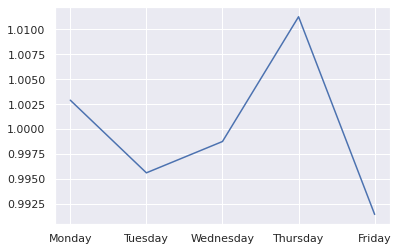

In [ ]:
vals = df["1991-05-05":"1991-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

([<matplotlib.axis.XTick at 0x7f59e399ce50>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday')])

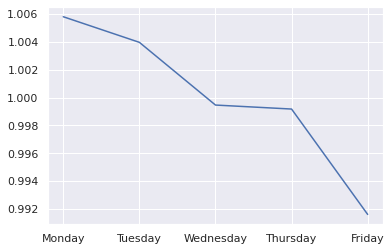

In [ ]:
vals = df["2001-05-05":"2001-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

([<matplotlib.axis.XTick at 0x7f59e3991250>,
 [Text(0, 0, 'Monday'),
  Text(0, 0, 'Tuesday'),
  Text(0, 0, 'Wednesday'),
  Text(0, 0, 'Thursday'),
  Text(0, 0, 'Friday')])

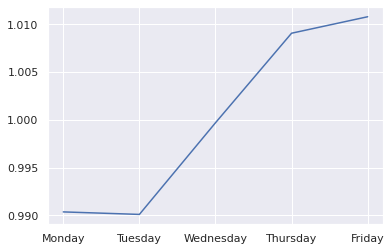

In [ ]:
vals = df["2018-05-05":"2018-05-11"].Close.values
mean_val = np.mean(vals)
plt.plot([1, 2, 3, 4, 5], vals/mean_val)
plt.xticks([1, 2, 3, 4, 5], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


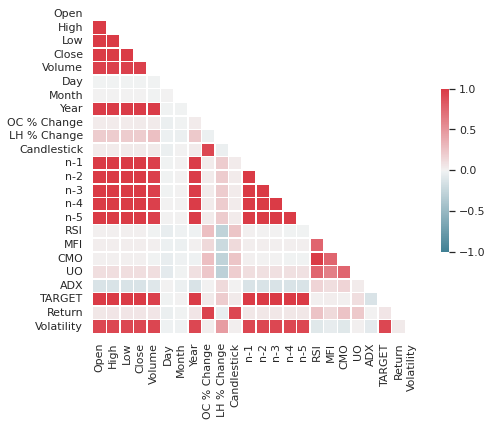

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

corr = df_reg.corr(method='spearman')
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

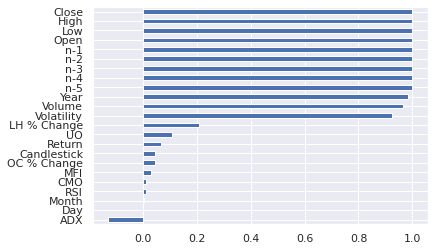

In [ ]:
sns.set()
df_reg.corr(method='spearman')['TARGET'].sort_values()[:-1].plot(kind='barh')

In [ ]:
X = df.drop('TARGET', axis=1).copy()
y = df['TARGET']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
import statsmodels.api as sm

X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])

predictors = ['const'] + list(X_train.columns)
sl = 0.05   #istotność statystyczna

for i in range(0, num_vars):
    ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
    max_pval = max(ols.pvalues.astype('float'))
    if max_pval > sl:
        for j in range(0, num_vars - i):
            if ols.pvalues[j].astype('float') == max_pval:
                X_train_numpy = np.delete(X_train_numpy, j, axis=1)
                predictors.remove(predictors[j])

print(ols.summary(xname=predictors))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     2423.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:13:31   Log-Likelihood:            -1.0427e+05
No. Observations:               13694   AIC:                         2.086e+05
Df Residuals:                   13679   BIC:                         2.087e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -37.6264      0.210   -179.145   

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import plotly.express as px
import plotly.graph_objects as go
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train.shape

(13695, 1, 21)

In [ ]:
def build_model_rnn():
    lstm = Sequential()
    lstm.add(LSTM(128, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=True))
    lstm.add(LSTM(64, return_sequences=True))
    lstm.add(Dense(1))
    lstm.compile(optimizer='adam', 
                 loss='mse',
                 metrics=['mae', 'mse'])

    return lstm

In [ ]:
model = build_model_rnn()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1, 128)            76800     
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dense_14 (Dense)            (None, 1, 1)              65        
                                                                 
Total params: 126,273
Trainable params: 126,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=500, validation_split=0.25, verbose=1, batch_size=32)

Epoch 1/500
321/321 [==============================] - 6s 8ms/step - loss: 1300234.3750 - mae: 682.7222 - mse: 1300234.3750 - val_loss: 1362968.2500 - val_mae: 696.5132 - val_mse: 1362968.2500
Epoch 2/500
321/321 [==============================] - 2s 6ms/step - loss: 1273975.0000 - mae: 663.9626 - mse: 1273975.0000 - val_loss: 1340320.2500 - val_mae: 682.2842 - val_mse: 1340320.2500
Epoch 3/500
321/321 [==============================] - 2s 6ms/step - loss: 1253066.8750 - mae: 651.0504 - mse: 1253066.8750 - val_loss: 1319343.5000 - val_mae: 670.4604 - val_mse: 1319343.5000
Epoch 4/500
321/321 [==============================] - 2s 6ms/step - loss: 1233336.3750 - mae: 640.4574 - mse: 1233336.3750 - val_loss: 1299268.6250 - val_mae: 660.3197 - val_mse: 1299268.6250
Epoch 5/500
321/321 [==============================] - 2s 6ms/step - loss: 1214465.0000 - mae: 631.5277 - mse: 1214465.0000 - val_loss: 1280026.6250 - val_mae: 651.6693 - val_mse: 1280026.6250
Epoch 6/500
321/321 [==============

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist['rmse'] = np.sqrt(hist['mse'])
    hist['val_rmse'] = np.sqrt(hist['val_mse'])

    fig  =go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['mae'], name='mae', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_mae'], name='val_mae', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='MAE vs. VAL_MAE', xaxis_title='Epoki', yaxis_title='Mean absolute error')
    fig.show()

    fig  =go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['rmse'], name='rmse', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_rmse'], name='val_rmse', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='RMSE vs. VAL_RMSE', xaxis_title='Epoki', yaxis_title='Root mean squared error')
    fig.show()

plot_history(history)

In [ ]:
test_predictions = model.predict(X_test).flatten()
pred = pd.DataFrame({'test': y_test})
pred['predictions'] = test_predictions

In [ ]:
fig = px.scatter(pred, 'test', 'predictions')
fig.add_trace(go.Scatter(x=[0, df.Close.max()], y=[0, df.Close.max()], mode='lines'))
fig.show()